<a href="https://colab.research.google.com/github/ebinjomonkottakal/Tensorflow_advanced/blob/main/Variational_AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

In [2]:
#Define the global constant to be used in the notebook
BATCH_SIZE = 128
LATENT_DIM = 2

# Prepare the Dataset

In [3]:
def map_image(image,label):
  image = tf.cast(image,tf.float32)/255.0
  image = tf.reshape(image,(28,28,1,))
  return image

def get_dataset(map_fn, is_validation=False):
  '''Loads and prepares the mnist dataset from TFDS.'''
  if is_validation:
    split_name = "test"
  else:
    split_name = "train"

  dataset = tfds.load('mnist', as_supervised=True, split=split_name)
  dataset = dataset.map(map_fn)
  
  if is_validation:
    dataset = dataset.batch(BATCH_SIZE)
  else:
    dataset = dataset.shuffle(1024).batch(BATCH_SIZE)

  return dataset

In [4]:
train_dataset = get_dataset(map_image)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


# Sampling

In [5]:
class Sampling(tf.keras.layers.Layer):
  def call(self,inputs):
    mu, sigma = inputs
    batch = tf.shape(mu)[0]
    dim = tf.shape(mu)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch,dim))
    return mu + tf.exp(0.5*sigma)*epsilon

# Encoder

In [6]:
def encoder_layers(input,latent_dim):
  x = tf.keras.layers.Conv2D(32,kernel_size=3,strides=2,padding='same',activation='relu',name='encode_conv1')(input)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Conv2D(64,kernel_size=3,strides=2,padding='same',activation='relu',name = 'encode_conv2')(x)

  batch_2 = tf.keras.layers.BatchNormalization()(x)

  x = tf.keras.layers.Flatten(name='encode_Flatten')(batch_2)
  x = tf.keras.layers.Dense(20,activation='relu',name='encode_dense')(x)
  mu = tf.keras.layers.Dense(latent_dim,name='latent_mu')(x)
  sigma = tf.keras.layers.Dense(latent_dim,name='latent_sigma')(x)
  return mu,sigma,batch_2.shape

In [7]:
def encoder_model(latent_dim,input_shape):
  inputs = tf.keras.layers.Input(shape=input_shape)
  mu,sigma,conv_shape = encoder_layers(inputs,latent_dim=LATENT_DIM)
  z = Sampling()((mu,sigma))
  model = tf.keras.Model(inputs,outputs=[mu,sigma,z])
  return model,conv_shape

# Decoder

In [8]:
def decoder_layers(inputs,conv_shape):
  unit = conv_shape[1]*conv_shape[2]*conv_shape[3]
  x = tf.keras.layers.Dense(unit,activation='relu',name='decode_dense1')(inputs)
  x = tf.keras.layers.BatchNormalization()(x)

    # reshape output using the conv_shape dimensions
  x = tf.keras.layers.Reshape((conv_shape[1], conv_shape[2], conv_shape[3]), name="decode_reshape")(x)

  # upsample the features back to the original dimensions
  x = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', activation='relu', name="decode_conv2d_2")(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu', name="decode_conv2d_3")(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=1, padding='same', activation='sigmoid', name="decode_final")(x)
  return x

In [9]:
def decoder_model(latent_dim, conv_shape):

  # set the inputs to the shape of the latent space
  inputs = tf.keras.layers.Input(shape=(latent_dim,))

  # get the output of the decoder layers
  outputs = decoder_layers(inputs, conv_shape)

  # declare the inputs and outputs of the model
  model = tf.keras.Model(inputs, outputs)
  
  return model

# Kullback–Leibler Divergence

In [10]:
def kl_reconstruction_loss(mu, sigma):


  kl_loss = 1 + sigma - tf.square(mu) - tf.math.exp(sigma)
  kl_loss = tf.reduce_mean(kl_loss) * -0.5

  return kl_loss

# VAE MODEL

In [11]:
def vae_model(encoder,decoder,input_shape):
  inputs = tf.keras.layers.Input(shape=input_shape)
  mu,sigma,z = encoder(inputs)
  reconstructed = decoder(z)
  model = tf.keras.Model(inputs = inputs,outputs=reconstructed)
  loss= kl_reconstruction_loss(mu,sigma)
  model.add_loss(loss)
  return model

In [12]:
def get_models(input_shape,latent_dim):
  encoder, conv_shape = encoder_model(latent_dim=latent_dim, input_shape=input_shape)
  decoder = decoder_model(latent_dim=latent_dim, conv_shape=conv_shape)
  vae = vae_model(encoder, decoder, input_shape=input_shape)
  return encoder, decoder, vae

In [13]:
# Get the encoder, decoder and 'master' model (called vae)
encoder, decoder, vae = get_models(input_shape=(28,28,1,), latent_dim=LATENT_DIM)

In [14]:
# Define our loss functions and optimizers
optimizer = tf.keras.optimizers.Adam()
loss_metric = tf.keras.metrics.Mean()
bce_loss = tf.keras.losses.BinaryCrossentropy()

In [15]:
def generate_and_save_images(model, epoch, step, test_input):
  """Helper function to plot our 16 images

  Args:

  model -- the decoder model
  epoch -- current epoch number during training
  step -- current step number during training
  test_input -- random tensor with shape (16, LATENT_DIM)
  """

  # generate images from the test input
  predictions = model.predict(test_input)

  # plot the results
  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0], cmap='gray')
      plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  fig.suptitle("epoch: {}, step: {}".format(epoch, step))
  plt.savefig('image_at_epoch_{:04d}_step{:04d}.png'.format(epoch, step))
  plt.show()

1/1 [==============================] - 0s 18ms/step


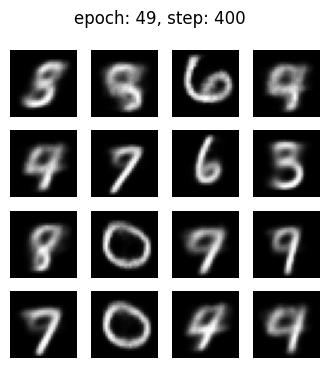

Epoch: 49 step: 400 mean loss = 146.23616


In [16]:
# Training loop. 

# generate random vector as test input to the decoder
random_vector_for_generation = tf.random.normal(shape=[16, LATENT_DIM])

# number of epochs
epochs = 50

# initialize the helper function to display outputs from an untrained model
generate_and_save_images(decoder, 0, 0, random_vector_for_generation)

for epoch in range(epochs):
  print('Start of epoch %d' % (epoch,))

  # iterate over the batches of the dataset.
  for step, x_batch_train in enumerate(train_dataset):
    with tf.GradientTape() as tape:

      # feed a batch to the VAE model
      reconstructed = vae(x_batch_train)

      # compute reconstruction loss
      flattened_inputs = tf.reshape(x_batch_train, shape=[-1])
      flattened_outputs = tf.reshape(reconstructed, shape=[-1])
      loss = bce_loss(flattened_inputs, flattened_outputs) * 784
      
      # add KLD regularization loss
      loss += sum(vae.losses)  

    # get the gradients and update the weights
    grads = tape.gradient(loss, vae.trainable_weights)
    optimizer.apply_gradients(zip(grads, vae.trainable_weights))

    # compute the loss metric
    loss_metric(loss)

    # display outputs every 100 steps
    if step % 100 == 0:
      display.clear_output(wait=False)    
      generate_and_save_images(decoder, epoch, step, random_vector_for_generation)
      print('Epoch: %s step: %s mean loss = %s' % (epoch, step, loss_metric.result().numpy()))

1/1 [==============================] - 0s 22ms/step


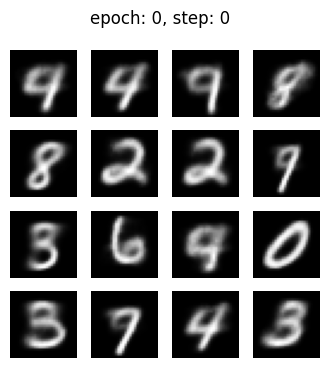

In [18]:
random_vector_for_generation = tf.random.normal(shape=[16, LATENT_DIM])


generate_and_save_images(decoder, 0, 0, random_vector_for_generation)
